# Deep Learning for Media
#### MPATE-GE 2039 - DM-GY 9103

---

## Homework 2

**Instructions:**

1. Complete parts 1 through 5, filling in code in the `utils.py` and `models.py` files where indicated **# YOUR CODE HERE** or responses in `this notebook` where marked with **# YOUR RESPONSE HERE**.
2. **Document** your code. Add comments explaining what the different parts of your code are doing.
3. If you copy code from external resources (which is fine), include references as comments.
4. When finished, commit and push this completed notebook file along with the `utils.py` file, `models.py` file, the `predictions_da.npy`, and the `predictions_tf.npy` to your GitHub repository corresponding to this homework.
5. **IMPORTANT:** do not modify any of the provided code unless indicated in the instructions.

**Grading:**

- This homework is worth 10 points.
- Each function you code is worth 1 point, for a total of 6 points.
- Each answer in part 4 is worth 1 point, for a total of 4 points.
- Points will be automatically assigned when passing tests and manually assigned when it comes to your written responses.

**Academic integrity:**

Remember that this homework should be authored by you only. It's ok to discuss with classmates but you have to submit your own original solution.

**Reference:**

Notebook based on the companion materials of:

<blockquote>
"Deep Learning with Python", Second Edition by  F. Chollet, 2021.
</blockquote>

You are encouraged to follow the code in `Chapter 8` from the book as help for this homework.

**IMPORTANT**: If you're running the code in Colab, run the cells below. Otherwise, comment them.

In [1]:
# This will automatically load any changes you make to your utils.py and models.py
# without having to restart your notebook
%load_ext autoreload
%autoreload 2

In [2]:
# if you're running the code locally, comment this cell
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# if not, make sure to upload your homework-2 folder to drive in the correct location

# replace <YOUR_GITHUB_USERNAME> with your github username
%cd /content/drive/MyDrive/dl4m/homework-2-jysim128-main

/content/drive/MyDrive/dl4m/homework-2-jysim128-main


## Small Data, Big Challenge: Improving Models with Data Augmentation and Transfer Learning

---

In this exercise, you will improve the performance of a convolutional model trained with a small dataset of dog and cat images. Many real-world applications involve small datasets. Therefore, it's essential for you to learn how to handle small datasets effectively.

You will start by training a simple convolutional model with the limited amount of data provided. You will then observe the model's overfitting behavior and identify the need for regularization techniques such as data augmentation. You will then augment the dataset and re-train the model.

Even with data augmentation, the model may not generalize well to new data due to the limited amount of training data variability. Therefore, you will use transfer learning, where you will leverage pre-trained models to improve the performance of your model. Happy coding!

**BEFORE YOU CONTINUE:** Make sure you're using GPU acceleration.

In [4]:
# This notebook is for visualization and written answers only
# Your code should go in utils.py and models.py
import utils as u # to use the functions from utils, do u.function()
import models as m # to use the functions from models, do m.function()

In [5]:
# Fix the random seed for reproducibility
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.keras.utils.set_random_seed(123)

## Part 1 - Organizing the data

Load the Dogs vs. Cats Small dataset (5000 samples), which consists of images of dogs and cats of different sizes. Check out the sizes of the different subsets (train, validation, test), and explore the data.

If you didn't download the dataset in the class practice of `week 6`, you can find the dataset in the following link:

https://bit.ly/dl4m_S25_dogs_vs_cats_small

Unzip the contents of the file using `ZIP Extractor` (available in Google Drive). Make sure that the unzipped folder is located at `/content/drive/My Drive/dl4m/dogs-vs-cats_small/`. After unzipping, verify that the folder structure is as follows:
```
--test
    --cat
        --cat.NUMBER.jpg
    --dog
        --dog.NUMBER.jpg
--train
    --cat
        --cat.NUMBER.jpg
    --dog
        --dog.NUMBER.jpg
--validation
      --cat
        --cat.NUMBER.jpg
      --dog
        --dog.NUMBER.jpg

```

In [6]:
import os

# IMPORTANT: if you running the code locally, change this path.
data_home = '/content/drive/My Drive/dl4m/dogs-vs-cats_small/'
if not os.path.exists(data_home):
  print('You should download the dataset first, unzip all its folders and '
  'locate it in the data_home folder.')

In [7]:
# Create datasets

target_shape = (180, 180)
batch_size = 32

train_dataset = u.create_dataset(os.path.join(data_home, 'train'),
                                 batch_size, target_shape)

val_dataset = u.create_dataset(os.path.join(data_home, 'validation'),
                               batch_size, target_shape)

test_dataset = u.create_dataset(os.path.join(data_home, 'test'),
                                batch_size, target_shape, shuffle=False)


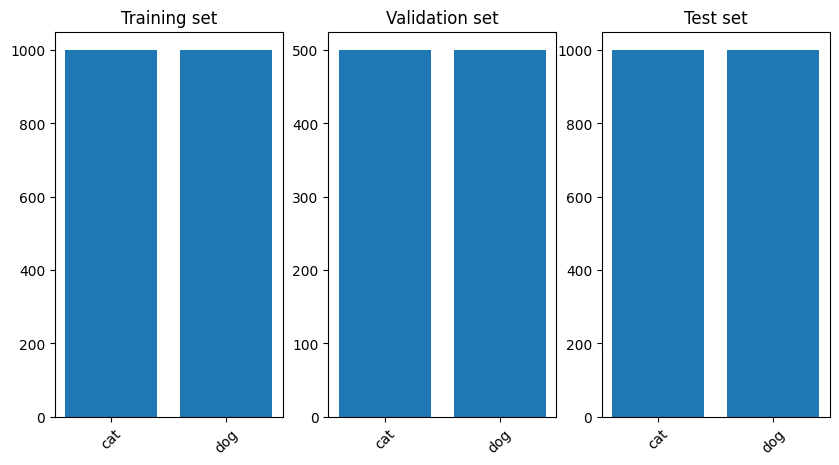

In [8]:
# Explore the data
# WARNING: loading all the data might take a bit of time
u.explore_data(train_dataset, data_home, ['cat', 'dog'])

## Part 2 - Build, train and evaluate a baseline

Build a convolutional baseline model that classifies cats vs. dogs. Note that your model should solve a binary classification problem.

In [9]:
# Build baseline
input_shape = (180, 180, 3)
baseline = m.build_baseline(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define callbacks
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="baseline.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train model
history = baseline.fit(
              train_dataset,
              validation_data=val_dataset,
              verbose=1,
              epochs=30,
              batch_size=batch_size,
              callbacks=callbacks)

Epoch 1/30
     63/Unknown 148s 2s/step - acc: 0.4920 - loss: 0.6984

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 342s 5s/step - acc: 0.4921 - loss: 0.6983 - val_acc: 0.5060 - val_loss: 0.6926
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 364ms/step - acc: 0.5237 - loss: 0.6919 - val_acc: 0.6000 - val_loss: 0.6686
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - acc: 0.5329 - loss: 0.6874 - val_acc: 0.5240 - val_loss: 0.6799
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - acc: 0.5905 - loss: 0.6616 - val_acc: 0.6440 - val_loss: 0.6222
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - acc: 0.6497 - loss: 0.6340 - val_acc: 0.6670 - val_loss: 0.6113
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - acc: 0.6622 - loss: 0.6181 - val_acc: 0.6590 - val_loss: 0.6293
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - acc: 0.6671 - loss: 0.6037 - val_acc: 0.6770 - val_loss: 0.5945
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 659ms/step - acc: 0.7091 - loss: 0.5536 - val_acc: 0.6970 - val_loss: 0.5721
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - acc: 0

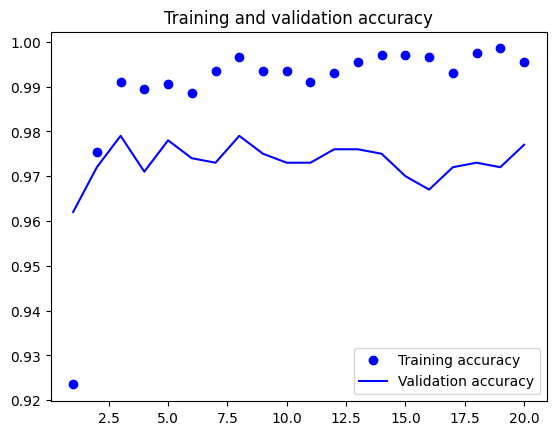

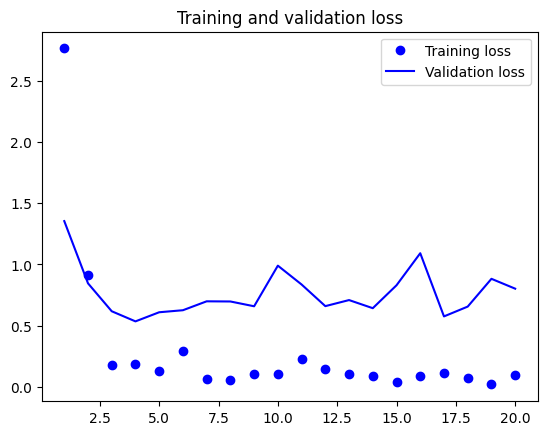

In [44]:
u.plot_loss(history)

In [25]:
# # Load the best checkpoint of the model
test_model = keras.models.load_model("baseline.keras")

# Evaluate model
loss, accuracy = test_model.evaluate(test_dataset)
print('Loss: %.4f, Accuracy: %.2f%%' % (loss, accuracy*100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 421s 6s/step - acc: 0.7035 - loss: 0.6110
Loss: 0.5897, Accuracy: 71.45%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Part 3 - Regularize the model

Regularize the model by using data augmentation and dropout. There are many different augmentations that you can apply to the model, we will do horizontal flipping (which you will implement) and random rotation (which is already implemented). Besides data augmentation, we will include a dropout layer to further regularize the model.

In [26]:
# Obtain the augmented datasets

train_dataset_aug = u.create_dataset(os.path.join(data_home, 'train'),
                                 batch_size, target_shape, augment=True)

val_dataset_aug = u.create_dataset(os.path.join(data_home, 'validation'),
                                 batch_size, target_shape, augment=True)


**Displaying some randomly augmented training images**

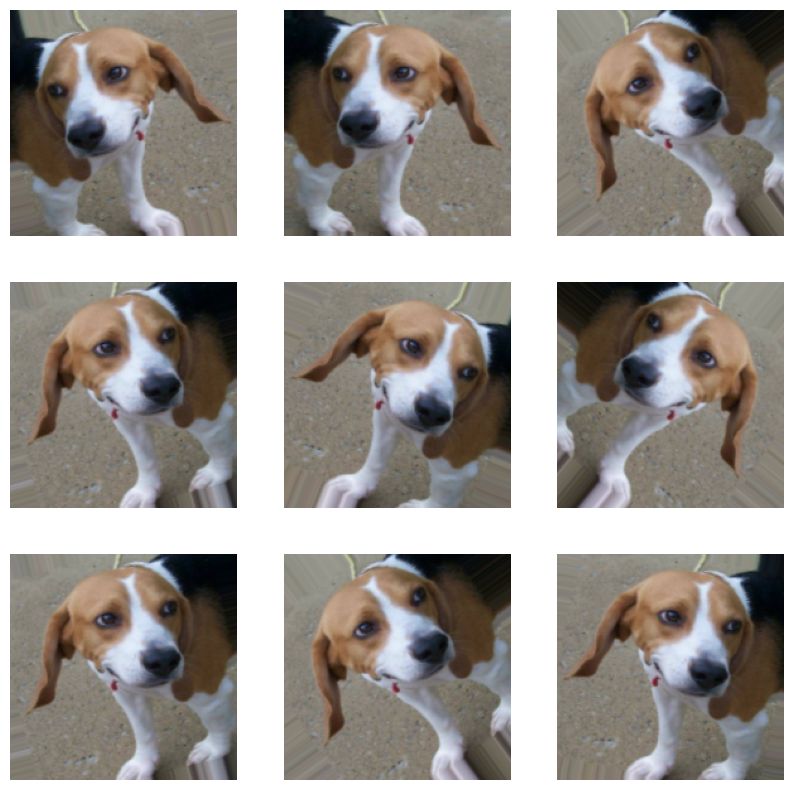

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for batch, _ in val_dataset_aug.take(1):
  for image in batch[:5]:
    # print(image.numpy().max())
    for i in range(9):
        aug_img = image.numpy()
        if np.random.rand() > 0.5:
          aug_img = u.flip_image(image.numpy())
        angle = np.random.uniform(-40, 40)
        aug_img = u.rotate_image(aug_img, angle)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img)
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [28]:
aug_model = m.build_reg_model(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
aug_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          20,737 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 409,153 (1.56 MB)

 Trainable params: 409,153 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Define callbacks
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="aug_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train model
history = aug_model.fit(
              train_dataset_aug,
              validation_data=val_dataset_aug,
              epochs=30,
              batch_size=batch_size,
              callbacks=callbacks)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 381ms/step - accuracy: 0.5175 - loss: 0.6950 - val_accuracy: 0.6500 - val_loss: 0.6470
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 363ms/step - accuracy: 0.6318 - loss: 0.6492 - val_accuracy: 0.6190 - val_loss: 0.6734
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 672ms/step - accuracy: 0.6795 - loss: 0.6136 - val_accuracy: 0.6510 - val_loss: 0.6193
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 417ms/step - accuracy: 0.7072 - loss: 0.5710 - val_accuracy: 0.7030 - val_loss: 0.5642
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 365ms/step - accuracy: 0.7514 - loss: 0.5220 - val_accuracy: 0.6855 - val_loss: 0.5738
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 425ms/step - accuracy: 0.7698 - loss: 0.5001 - val_accuracy: 0.7330 - val_loss: 0.5306
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.7854 - loss: 0.4711 - val_accuracy: 0.7380 - val_loss: 0.5208
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 413ms/step - accuracy: 0.8001 - loss: 0

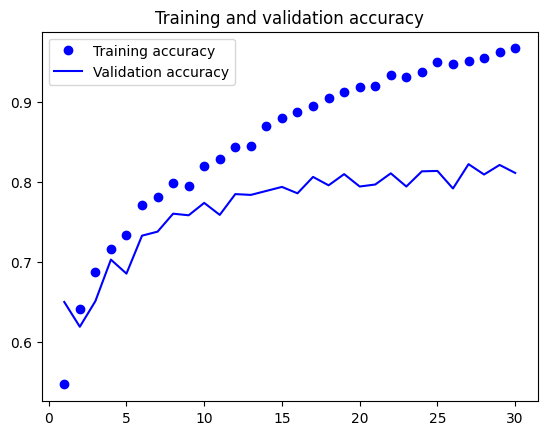

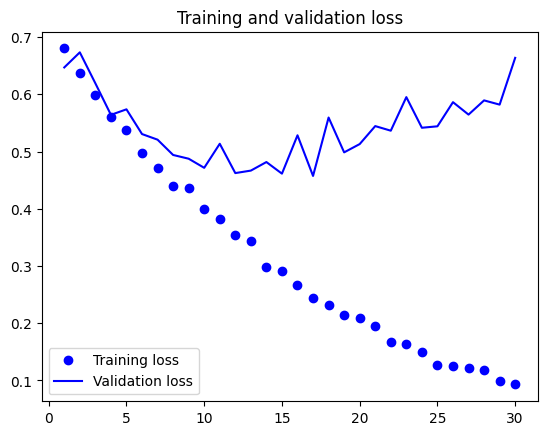

In [31]:
u.plot_loss(history)

In [33]:
# Load the best checkpoint of the model
aug_model = keras.models.load_model("aug_model.keras")

# Evaluate model
loss, accuracy = aug_model.evaluate(test_dataset)
print('Loss: %.4f, Accuracy: %.2f%%' % (loss, accuracy*100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.7772 - loss: 0.5903
Loss: 0.5026, Accuracy: 80.20%


In [34]:
# Save predictions
import numpy as np
np.save('results/predictions_da.npy', aug_model.predict(test_dataset))

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step


## Part 4 - Leveraging a pretrained model

We are going to use the VGG16 convolutional model trained with Imagenet as our pre-trained model. We will extract features from it, and use them to train a small classifier build from dense layers.

**Instantiating the VGG16 convolutional base**

In [35]:
conv_base = m.load_conv_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Extracting the VGG16 features and corresponding labels**

In [37]:
# Create datasets

train_dataset = u.create_dataset(os.path.join(data_home, 'train'),
                                 batch_size, target_shape, normalize=False)

val_dataset = u.create_dataset(os.path.join(data_home, 'validation'),
                               batch_size, target_shape, normalize=False)

test_dataset = u.create_dataset(os.path.join(data_home, 'test'),
                                batch_size, target_shape,
                                shuffle=False, normalize=False)


In [38]:
import numpy as np

train_features, train_labels =  u.get_features_and_labels(train_dataset, conv_base)
val_features, val_labels =  u.get_features_and_labels(val_dataset, conv_base)
test_features, test_labels =  u.get_features_and_labels(test_dataset, conv_base)

In [39]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [40]:
dense_model = m.build_dense_model(input_shape=train_features.shape[1:])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = dense_model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8793 - loss: 3.7940 - val_accuracy: 0.9620 - val_loss: 1.3537
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9716 - loss: 1.1139 - val_accuracy: 0.9720 - val_loss: 0.8454
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9914 - loss: 0.1471 - val_accuracy: 0.9790 - val_loss: 0.6173
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9906 - loss: 0.2153 - val_accuracy: 0.9710 - val_loss: 0.5346
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.1823 - val_accuracy: 0.9780 - val_loss: 0.6091
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9894 - loss: 0.4131 - val_accuracy: 0.9740 - val_loss: 0.6257
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9944 - loss: 0.0982 - val_accuracy: 0.9730 - val_loss: 0.6985
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0510 - val_accuracy: 0.9790 - val_loss

**Plotting the results**

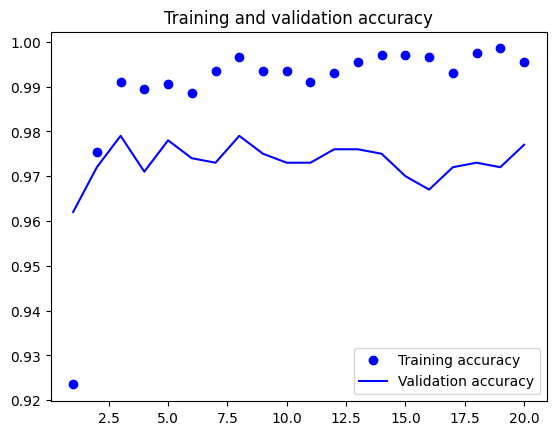

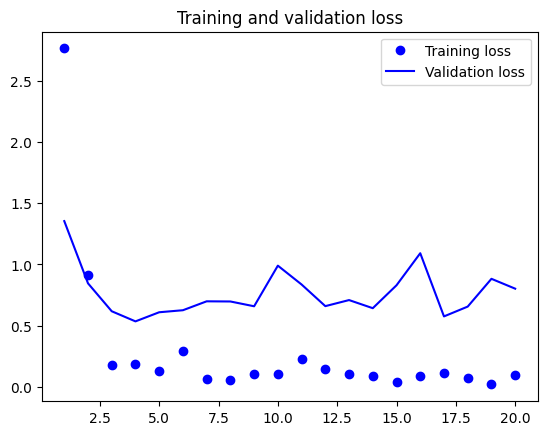

In [41]:
u.plot_loss(history)

In [42]:
# Load the best checkpoint of the model
transf_model = keras.models.load_model("feature_extraction.keras")

# Evaluate model
loss, accuracy = transf_model.evaluate(test_features, test_labels)
print('Loss: %.4f, Accuracy: %.2f%%' % (loss, accuracy*100))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9811 - loss: 0.5520
Loss: 0.9056, Accuracy: 97.10%


In [43]:
# Save predictions
np.save('results/predictions_tl.npy', transf_model.predict(test_features))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Part 5 - Discuss the problem

1. What is overfitting? How does it affect the performance of a model trained on a small dataset? Provide an example.

Overfitting means the model trains the data too well. It is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data (Chollet, 2017). If overfitting happens, after a few epochs, the accuracy got a peak, but it degrades quickly. For example, in the first training of this assignment, overfitting can be observed. The 20th epoch showed 100% of the accuracy, but after that the validation accuracy started to drop and validation loss also began to be increased.

2. What are the benefits of data augmentation in improving the performance of a model trained on a small dataset? Provide an example of a data augmentation technique that could be used in this exercise other than flipping and rotation.

The data augmentation has a benefit of expanding dataset by generating more training data that is perceivable to a model, which is helpful to prevent the overfitting. The goal of data augmentation is making your model not look at the exact same data twice. This helps expose the model to more aspects of the data and generalize better. In Keras, ImageDataGenerator instance helps to perform data augmentation. In this instance, there are many augmentation techniques such as flipping, rotating, shifting(width-shift, height-shift), shearing(shear-range), zooming(zoom-range), and filling(fill-mode).

3. What is transfer learning? How can it be used to improve the performance of a model trained on a small dataset? Provide an example of a pre-trained model that could be used in this exercise beyond VGG16.

Transfer learning means using a pretrained network. This pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classifcation task. Thus, the original dataset, which is large and generalized enough, can effectively act as a generic model of the small dataset, even if they don't have different classes. However, in this case, VGG16 is a widely used convnet architecture for ImageNet dataset, which has mostly animals and everyday objects. Thus, VGG16 works perfectly for this simple cats and dogs classification task. There are two ways to use a pretrained network: feature extraction and fine-tuning. Feature extraction consists of

4. What problems are you interested in where transfer learning might be useful and why?

`# YOUR RESPONSE HERE`